⏳ Chargement des données depuis : afcon.csv ...
✅ Fichier chargé avec succès ! (Taille: (49, 22))

📊 1/3 - Génération du graphique de possession...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25412\1358247280.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Resultat_Match', y='Team 1 Possession percentage',


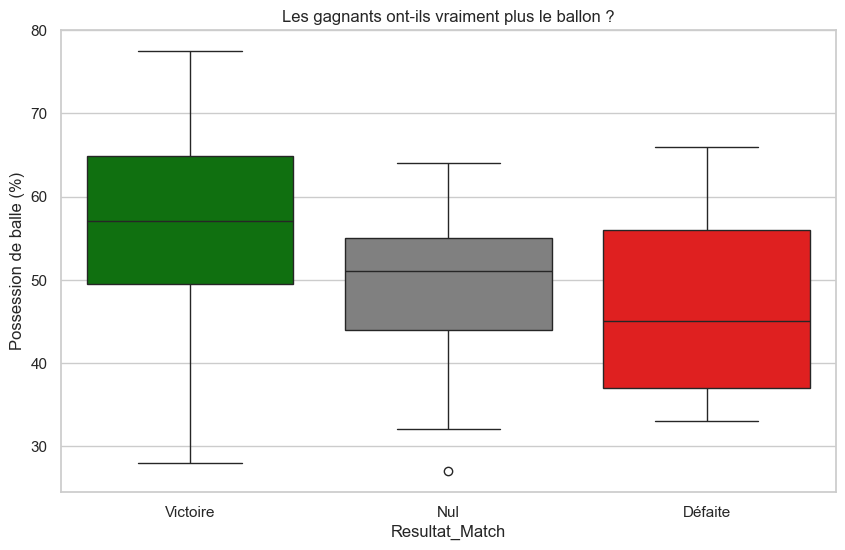


⏳ 2/3 - Extraction des buteurs pour la Heatmap...


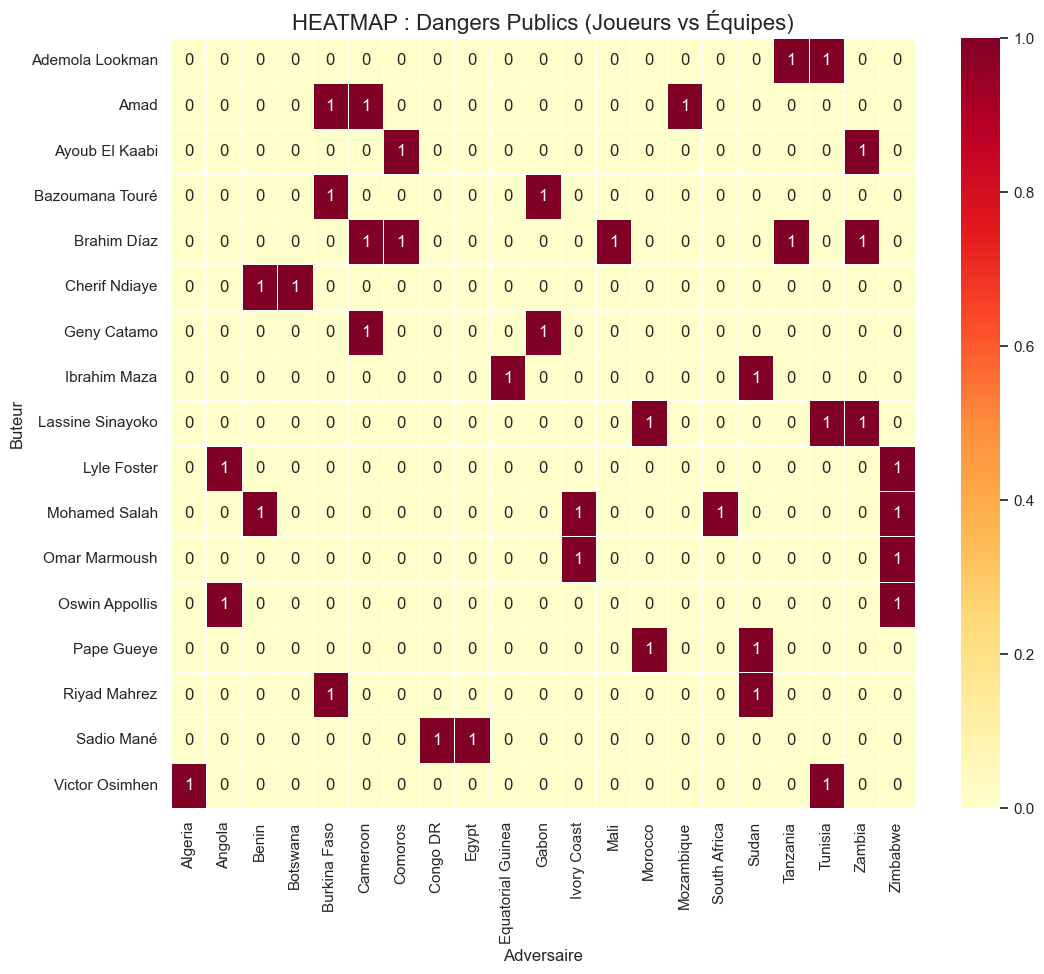


📊 3/3 - Génération du Jointplot (Possession vs Buts)...


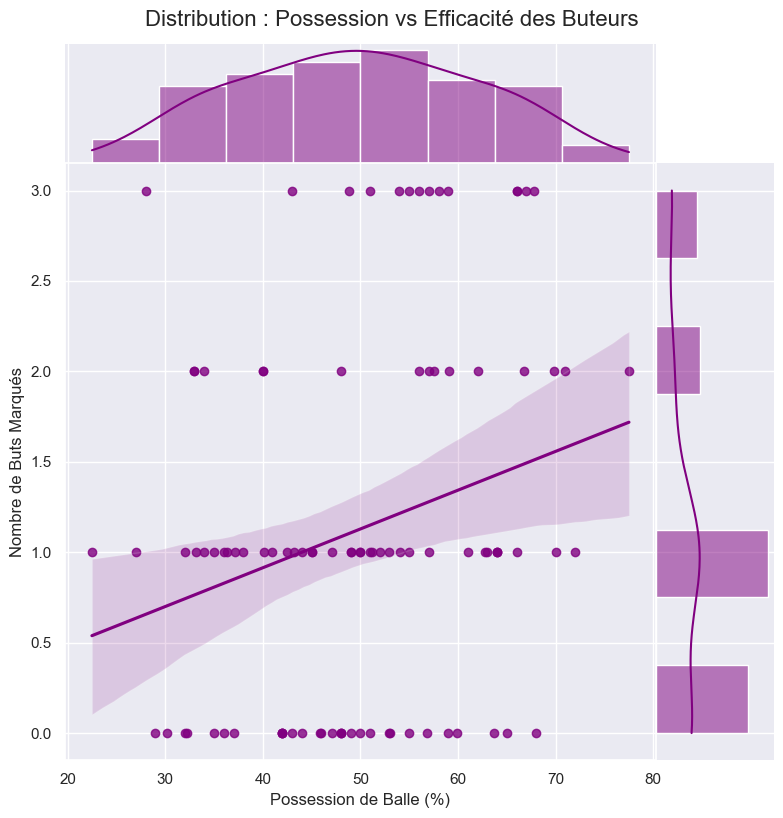

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import os

# ==========================================
# 📁 1. LE CHEMIN INTELLIGENT (FILEPATH)
# ==========================================
# Le code teste les deux chemins automatiquement pour être sûr à 100% !
if os.path.exists("02-Sports-Analytics/afcon.csv"):
    csv_path = "02-Sports-Analytics/afcon.csv"
else:
    csv_path = "afcon.csv"

try:
    print(f"⏳ Chargement des données depuis : {csv_path} ...")
    df = pd.read_csv(csv_path, on_bad_lines='skip')
    print(f"✅ Fichier chargé avec succès ! (Taille: {df.shape})")

    # ==========================================
    # ⚙️ 2. PRÉPARATION DES DONNÉES (SCORES)
    # ==========================================
    if 'Score (Team1 - Team2)' in df.columns:
        split_data = df['Score (Team1 - Team2)'].str.split(' - ', expand=True)
        df['Goals_Team1'] = pd.to_numeric(split_data[0])
        df['Goals_Team2'] = pd.to_numeric(split_data[1])
        
        conditions = [
            (df['Goals_Team1'] > df['Goals_Team2']), 
            (df['Goals_Team1'] < df['Goals_Team2']), 
            (df['Goals_Team1'] == df['Goals_Team2'])
        ]
        choices = ['Victoire', 'Défaite', 'Nul']
        df['Resultat_Match'] = np.select(conditions, choices, default='Indéfini')

        # ==========================================
        # 📊 3. VISUALISATION 1 : POSSESSION
        # ==========================================
        print("\n📊 1/3 - Génération du graphique de possession...")
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x='Resultat_Match', y='Team 1 Possession percentage', 
                    order=['Victoire', 'Nul', 'Défaite'],
                    palette={'Victoire': 'green', 'Défaite': 'red', 'Nul': 'gray'})
        plt.title("Les gagnants ont-ils vraiment plus le ballon ?")
        plt.ylabel("Possession de balle (%)")
        plt.show()

        # ==========================================
        # 🔥 4. VISUALISATION 2 : HEATMAP
        # ==========================================
        print("\n⏳ 2/3 - Extraction des buteurs pour la Heatmap...")
        goals_data = []

        def extraire_buteurs(texte_buteurs, equipe_adverse):
            if pd.isna(texte_buteurs): return
            buteurs = re.findall(r"([a-zA-ZÀ-ÿ\s\.-]+)(?: - \d+)", str(texte_buteurs))
            for joueur in buteurs:
                joueur_clean = joueur.strip()
                if len(joueur_clean) > 2:
                    goals_data.append({'Joueur': joueur_clean, 'Contre_Equipe': equipe_adverse})

        for index, row in df.iterrows():
            extraire_buteurs(row['Goal Scorers Team 1'], row['Team2'])
            extraire_buteurs(row['Goal Scorers Team 2'], row['Team1'])

        df_goals = pd.DataFrame(goals_data)
        top_players = df_goals['Joueur'].value_counts()
        top_scorers_list = top_players[top_players >= 2].index
        df_top = df_goals[df_goals['Joueur'].isin(top_scorers_list)]

        if not df_top.empty:
            heatmap_data = pd.crosstab(df_top['Joueur'], df_top['Contre_Equipe'])
            plt.figure(figsize=(12, 10))
            sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", linewidths=.5)
            plt.title("HEATMAP : Dangers Publics (Joueurs vs Équipes)", fontsize=16)
            plt.xlabel("Adversaire")
            plt.ylabel("Buteur")
            plt.yticks(rotation=0)
            plt.show()

        # ==========================================
        # 🎯 5. VISUALISATION 3 : JOINTPLOT
        # ==========================================
        print("\n📊 3/3 - Génération du Jointplot (Possession vs Buts)...")
        team1_stats = df[['Team 1 Possession percentage', 'Goals_Team1']].copy()
        team1_stats.columns = ['Possession', 'Buts']
        team2_stats = df[['Team 2 Possession percentage', 'Goals_Team2']].copy()
        team2_stats.columns = ['Possession', 'Buts']

        df_final = pd.concat([team1_stats, team2_stats])

        sns.set_theme(style="darkgrid")
        g = sns.jointplot(data=df_final, x='Possession', y='Buts', 
                          kind='reg', color='purple', height=8, space=0)
        
        g.fig.suptitle("Distribution : Possession vs Efficacité des Buteurs", y=1.02, fontsize=16)
        g.set_axis_labels("Possession de Balle (%)", "Nombre de Buts Marqués", fontsize=12)
        plt.show()

    else:
        print("⚠️ La colonne 'Score (Team1 - Team2)' est introuvable.")

except FileNotFoundError:
    print(f"\n❌ ERREUR : Impossible de trouver le fichier CSV.")
except Exception as e:
    print(f"\n❌ Une erreur inattendue est survenue : {e}")